<a href="https://colab.research.google.com/github/WoradeeKongthong/nature_multilabel_image_classification/blob/main/04_pretrained_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CTRL + A then CTRL + / to uncomment
# CLONE PROJECT TO TRAIN IN GOOGLE COLAB
import os
if os.path.isdir('/content/nature_multilabel_image_classification'):
  !rm -rf '/content/nature_multilabel_image_classification'
  
!git clone https://github.com/WoradeeKongthong/nature_multilabel_image_classification.git

if not os.getcwd() == '/content/nature_multilabel_image_classification' :
  %cd /content/nature_multilabel_image_classification

!pwd

Cloning into 'nature_multilabel_image_classification'...
remote: Enumerating objects: 2066, done.
remote: Counting objects: 100% (2066/2066), done.
remote: Compressing objects: 100% (2053/2053), done.
remote: Total 2066 (delta 21), reused 2041 (delta 8), pack-reused 0
Receiving objects: 100% (2066/2066), 218.29 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/nature_multilabel_image_classification
/content/nature_multilabel_image_classification


In [2]:
# prepared dataset
dataset_path = 'data/nature_data.npz'

# saved model name
model_name = 'best_pretrained_ResNet50.h5'

# Nature Image Classification (Multi-labels)

## Objective 
To learn tags given to each image.  
There are 5 tags;  
- desert  
- mountains  
- sea  
- sunset  
- trees  

## Dataset
source : https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip?dl=0  
(You can follow the tutorial in this blog https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24)

## Approach
Baseline model : CNN model with 1,2 or 3 VGG block(s)  

Improved model 
- dropout
- data augmentation

## Load dataset from file

In [3]:
import numpy as np

In [4]:
# load data
data = np.load(dataset_path)
X, y = data['arr_0'], data['arr_1']
print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (2000, 128, 128, 3)
y shape :  (2000, 5)


## Create train and test set
(Note : validation set will be created with ImageDataGenerator)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [7]:
print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print()
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (1600, 128, 128, 3)
y_train shape :  (1600, 5)

X_test shape :  (400, 128, 128, 3)
y_test shape :  (400, 5)


## Create data generator without data augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

In [9]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

## fbeta score function for multi-label problem

In [10]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [11]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Baseline Model

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [13]:
# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

94781440/94765736 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

Epoch 1/200
64/64 [==============================] - 40s 109ms/step - loss: 0.7183 - fbeta: 0.7339 - val_loss: 0.2464 - val_fbeta: 0.7729
Epoch 2/200
64/64 [==============================] - 6s 88ms/step - loss: 0.1186 - fbeta: 0.9110 - val_loss: 0.2436 - val_fbeta: 0.8093
Epoch 3/200
64/64 [==============================] - 6s 88ms/step - loss: 0.0583 - fbeta: 0.9581 - val_loss: 0.2809 - val_fbeta: 0.8124
Epoch 4/200
64/64 [==============================] - 6s 89ms/step - loss: 0.0361 - fbeta: 0.9741 - val_loss: 0.2948 - val_fbeta: 0.8261
Epoch 5/200
64/64 [==============================] - 6s 88ms/step - loss: 0.0259 - fbeta: 0.9862 - val_loss: 0.3142 - val_fbeta: 0.8140
Epoch 6/200
64/64 [==============================] - 6s 89ms/step - loss: 0.0151 - fbeta: 0.9909 - val_loss: 0.3090 - val_fbeta: 0.8375
Epoch 7/200
64/64 [==============================] - 6s 90ms/step - loss: 0.0120 - fbeta: 0.9959 - val_loss: 0.2903 - val_fbeta: 0.8457
Epoch 8/200
64/64 [===========================

In [16]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

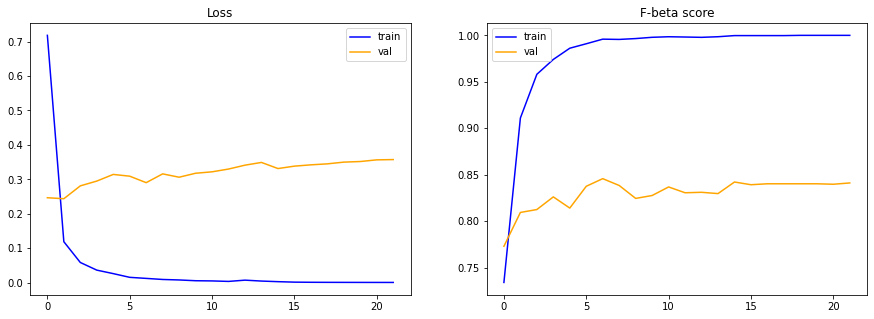

Model F-beta score :  0.8384124636650085


In [17]:
baseline_perf = evaluate_model(history)

Note : overfitting

## Improved Models

### model 1 : set last block as trainable

Epoch 1/200
64/64 [==============================] - 12s 108ms/step - loss: 0.5537 - fbeta: 0.7588 - val_loss: 0.3914 - val_fbeta: 0.7670
Epoch 2/200
64/64 [==============================] - 6s 90ms/step - loss: 0.0755 - fbeta: 0.9511 - val_loss: 0.2827 - val_fbeta: 0.8647
Epoch 3/200
64/64 [==============================] - 6s 90ms/step - loss: 0.0221 - fbeta: 0.9886 - val_loss: 0.3197 - val_fbeta: 0.8424
Epoch 4/200
64/64 [==============================] - 6s 90ms/step - loss: 0.0079 - fbeta: 0.9969 - val_loss: 0.3183 - val_fbeta: 0.8435
Epoch 5/200
64/64 [==============================] - 6s 90ms/step - loss: 0.0032 - fbeta: 0.9996 - val_loss: 0.3244 - val_fbeta: 0.8441
Epoch 6/200
64/64 [==============================] - 6s 90ms/step - loss: 0.0016 - fbeta: 0.9998 - val_loss: 0.3167 - val_fbeta: 0.8442
Epoch 7/200
64/64 [==============================] - 6s 90ms/step - loss: 0.0013 - fbeta: 0.9998 - val_loss: 0.3307 - val_fbeta: 0.8395
Epoch 8/200
64/64 [===========================

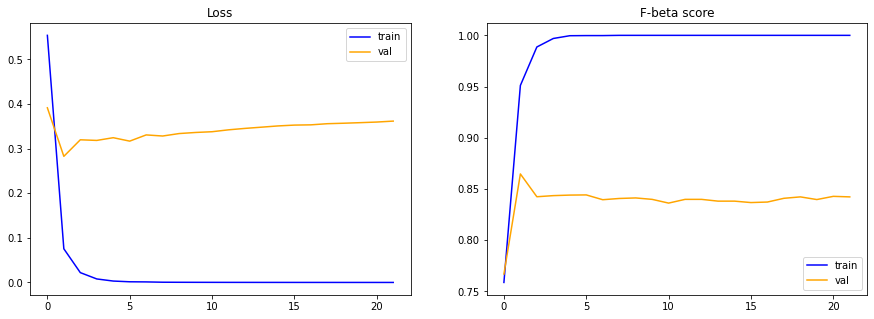

Model F-beta score :  0.8508242964744568


In [18]:
# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last block as trainable
model.get_layer('conv5_block3_3_conv').trainable = True
model.get_layer('conv5_block3_3_bn').trainable = True
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model1_perf = evaluate_model(history)

Note : overfitting, the performance is little higher than baseline model

### model 2 : Baseline + dropout layer

Epoch 1/200
64/64 [==============================] - 11s 108ms/step - loss: 0.5859 - fbeta: 0.7080 - val_loss: 0.2526 - val_fbeta: 0.8054
Epoch 2/200
64/64 [==============================] - 6s 88ms/step - loss: 0.2140 - fbeta: 0.8654 - val_loss: 0.2446 - val_fbeta: 0.8416
Epoch 3/200
64/64 [==============================] - 6s 88ms/step - loss: 0.1563 - fbeta: 0.9030 - val_loss: 0.2580 - val_fbeta: 0.8307
Epoch 4/200
64/64 [==============================] - 6s 88ms/step - loss: 0.1134 - fbeta: 0.9125 - val_loss: 0.2525 - val_fbeta: 0.8159
Epoch 5/200
64/64 [==============================] - 6s 88ms/step - loss: 0.1104 - fbeta: 0.9256 - val_loss: 0.2318 - val_fbeta: 0.8444
Epoch 6/200
64/64 [==============================] - 6s 87ms/step - loss: 0.0786 - fbeta: 0.9403 - val_loss: 0.2202 - val_fbeta: 0.8275
Epoch 7/200
64/64 [==============================] - 6s 88ms/step - loss: 0.0696 - fbeta: 0.9537 - val_loss: 0.2425 - val_fbeta: 0.8326
Epoch 8/200
64/64 [===========================

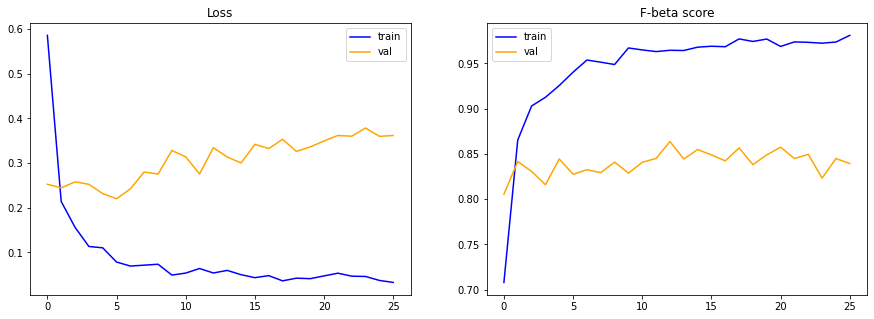

Model F-beta score :  0.8456944823265076


In [24]:
# create image data generator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)

# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model2_perf = evaluate_model(history)

Note : over fitting still occurs, the performance is higher than baseline model

### model 3 : Baseline model + data augmentation

Epoch 1/200
64/64 [==============================] - 13s 155ms/step - loss: 0.9146 - fbeta: 0.5910 - val_loss: 0.4711 - val_fbeta: 0.6686
Epoch 2/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3432 - fbeta: 0.7417 - val_loss: 0.3468 - val_fbeta: 0.7844
Epoch 3/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2901 - fbeta: 0.7792 - val_loss: 0.3593 - val_fbeta: 0.7926
Epoch 4/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2601 - fbeta: 0.7989 - val_loss: 0.4204 - val_fbeta: 0.6901
Epoch 5/200
64/64 [==============================] - 9s 136ms/step - loss: 0.2649 - fbeta: 0.8112 - val_loss: 0.3499 - val_fbeta: 0.7560
Epoch 6/200
64/64 [==============================] - 9s 136ms/step - loss: 0.2234 - fbeta: 0.8372 - val_loss: 0.3260 - val_fbeta: 0.7586
Epoch 7/200
64/64 [==============================] - 9s 138ms/step - loss: 0.2045 - fbeta: 0.8499 - val_loss: 0.3399 - val_fbeta: 0.7494
Epoch 8/200
64/64 [=====================

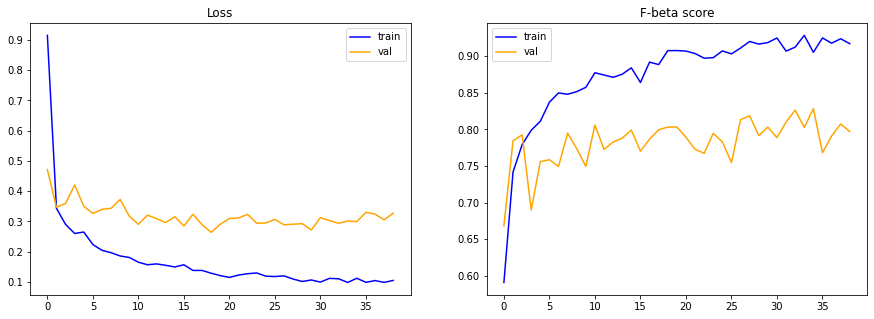

Model F-beta score :  0.852611780166626


In [20]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model3_perf = evaluate_model(history)

Note : 

### model 4 : Baseline model + data augmentation + dropout layers

Epoch 1/200
64/64 [==============================] - 14s 153ms/step - loss: 0.9321 - fbeta: 0.5399 - val_loss: 0.3951 - val_fbeta: 0.6317
Epoch 2/200
64/64 [==============================] - 9s 135ms/step - loss: 0.3853 - fbeta: 0.6423 - val_loss: 0.3359 - val_fbeta: 0.6782
Epoch 3/200
64/64 [==============================] - 9s 138ms/step - loss: 0.3620 - fbeta: 0.6732 - val_loss: 0.3189 - val_fbeta: 0.6966
Epoch 4/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3310 - fbeta: 0.6967 - val_loss: 0.2864 - val_fbeta: 0.7390
Epoch 5/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3063 - fbeta: 0.7074 - val_loss: 0.3040 - val_fbeta: 0.7020
Epoch 6/200
64/64 [==============================] - 9s 136ms/step - loss: 0.2744 - fbeta: 0.7386 - val_loss: 0.2816 - val_fbeta: 0.7432
Epoch 7/200
64/64 [==============================] - 9s 136ms/step - loss: 0.2876 - fbeta: 0.7371 - val_loss: 0.2692 - val_fbeta: 0.7658
Epoch 8/200
64/64 [=====================

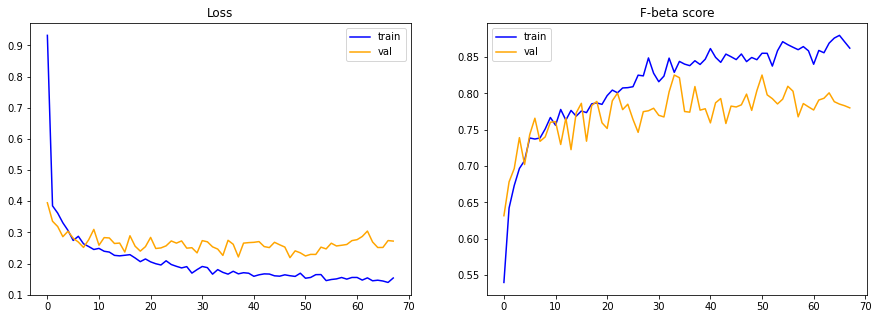

Model F-beta score :  0.8614880442619324


In [21]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model4_perf = evaluate_model(history)

Note : overfitting is reduced

### model 5 : set last block trainable + data augmentation + dropout layer

Epoch 1/200
64/64 [==============================] - 14s 157ms/step - loss: 0.6698 - fbeta: 0.6086 - val_loss: 0.3771 - val_fbeta: 0.6918
Epoch 2/200
64/64 [==============================] - 9s 139ms/step - loss: 0.3375 - fbeta: 0.7141 - val_loss: 0.3087 - val_fbeta: 0.6649
Epoch 3/200
64/64 [==============================] - 9s 137ms/step - loss: 0.2934 - fbeta: 0.7427 - val_loss: 0.3147 - val_fbeta: 0.7439
Epoch 4/200
64/64 [==============================] - 9s 137ms/step - loss: 0.2995 - fbeta: 0.7278 - val_loss: 0.3011 - val_fbeta: 0.7599
Epoch 5/200
64/64 [==============================] - 9s 137ms/step - loss: 0.2549 - fbeta: 0.7611 - val_loss: 0.3075 - val_fbeta: 0.7592
Epoch 6/200
64/64 [==============================] - 9s 137ms/step - loss: 0.2234 - fbeta: 0.7945 - val_loss: 0.3002 - val_fbeta: 0.7491
Epoch 7/200
64/64 [==============================] - 9s 138ms/step - loss: 0.2155 - fbeta: 0.8065 - val_loss: 0.2662 - val_fbeta: 0.7914
Epoch 8/200
64/64 [=====================

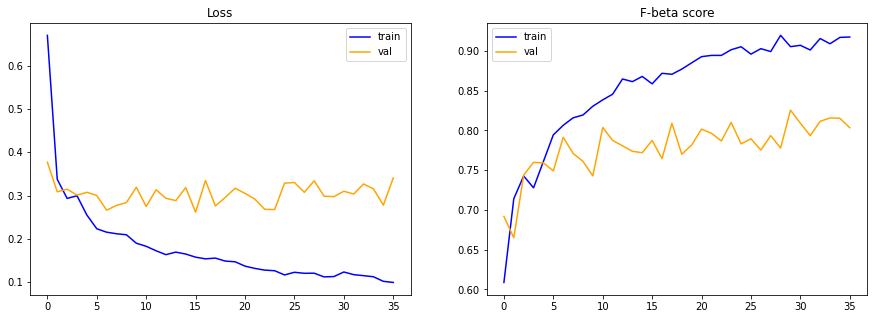

Model F-beta score :  0.8325361013412476


In [22]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last block as trainable
model.get_layer('conv5_block3_3_conv').trainable = True
model.get_layer('conv5_block3_3_bn').trainable = True
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model5_perf = evaluate_model(history)

Note : overfitting, but the performance (fbeta score) is high

## Model performance

In [25]:
print('Baseline model : ', baseline_perf)
print('model 1 : ', model1_perf)
print('model 2 : ', model2_perf)
print('model 3 : ', model3_perf)
print('model 4 : ', model4_perf)
print('model 5 : ', model5_perf)

Baseline model :  0.8384124636650085
model 1 :  0.8508242964744568
model 2 :  0.8456944823265076
model 3 :  0.852611780166626
model 4 :  0.8614880442619324
model 5 :  0.8325361013412476


Note : only model 4 is not high overfitting

## Finalize model 4
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.

Epoch 1/300
64/64 [==============================] - 14s 158ms/step - loss: 0.7860 - fbeta: 0.4751 - val_loss: 0.3928 - val_fbeta: 0.5466

Epoch 00001: val_loss improved from inf to 0.39283, saving model to best_pretrained_ResNet50.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
64/64 [==============================] - 9s 136ms/step - loss: 0.4158 - fbeta: 0.5092 - val_loss: 0.3368 - val_fbeta: 0.5901

Epoch 00002: val_loss improved from 0.39283 to 0.33679, saving model to best_pretrained_ResNet50.h5
Epoch 3/300
64/64 [==============================] - 9s 135ms/step - loss: 0.3862 - fbeta: 0.5753 - val_loss: 0.3315 - val_fbeta: 0.6585

Epoch 00003: val_loss improved from 0.33679 to 0.33151, saving model to best_pretrained_ResNet50.h5
Epoch 4/300
64/64 [==============================] - 9s 136ms/step - loss: 0.3777 - fbeta: 0.5763 - val_loss: 0.2991 - val_fbeta: 0.6970

Epoch 00004: val_loss improved from 0.33151 to 0.29910, saving model to best_pretrained_ResNet50.h5
Epoch 5/300
64/64 [==============================] - 9s 135ms/step - loss: 0.3669 - fbeta: 0.5711 - val_loss: 0.3191 - val_fbeta: 0.6620

Epoch 00005: val_loss did not improve from 0.29910
Epoch 6/300
64/64 [==============================] - 9s 133ms/step - loss: 0.3453 - fbeta: 0.6378

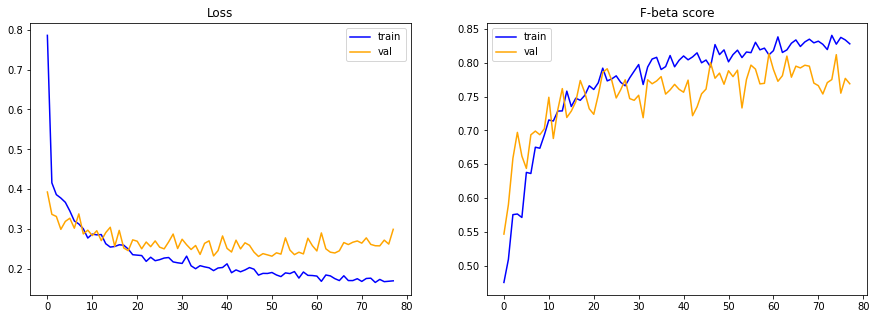

Model F-beta score :  0.8373396396636963


In [27]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.3)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# create model checkpoint to save the model
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es, mc],
                    epochs=300)
final_model_perf = evaluate_model(history)

## Evaluate model

In [28]:
# print model score
final_model_fbeta = model.evaluate(test_iter)[1]
print('final_model_fbeta : ', final_model_fbeta)

400/400 [==============================] - 8s 21ms/step - loss: 0.2022 - fbeta: 0.8373
final_model_fbeta :  0.8373396396636963


## Save model to local machine

In [29]:
# load saved model file to local machine
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>